In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
import pandas as pd

from qtrendutils import linfit_utils as linfit
from qtrendutils import colormap_utils as mycolors

from matplotlib.colors import BoundaryNorm
plt.rc('font', family='Arial')

import sys
from matplotlib import colors as c
from qtrendutils import colorbar_utils as cbars
from qtrendutils import calendar_utils as cal

In [2]:
plotpath="/project/cas/islas/python_plots/qtrend_paper/figures/supplemental/"

In [3]:
era5 = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/vaporpressures/vaporpressures_ERA5_USSW.nc").vp
era5_am = cal.calcannualmean(era5)
#era5_am = era5.groupby('time.year').mean('time')
#isd_vp_sw = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/vaporpressures/vaporpressures_ISD_USSW_fromhourly_ge4pd.nc").sel(time=slice("1980-01-01","2020-12-31")).vp
#isd_am = isd_vp_sw.groupby('time.year').mean('time')

In [4]:
### ISD
basepath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/"
isd_vp_swstat = xr.open_dataset(basepath+'vaporpressures/vaporpressures_ISD_USSW_fromhourly_ge4pd_swstations.nc').sel(time=slice("1980-01-01","2020-12-31"))

# drop the lons and lats and weights for now
isd_sw_lons = isd_vp_swstat.lons ; isd_sw_lats = isd_vp_swstat.lats ; isd_sw_wgts = isd_vp_swstat.area_weights
isd_vp_swstat = isd_vp_swstat.drop_vars(['lons','lats', 'area_weights'])
isd_vp_swstat = isd_vp_swstat.vp

# compute the seasonal cycle
isd_sw_seascyc = isd_vp_swstat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
isd_sw_deseas = isd_vp_swstat.groupby('time.month') - isd_sw_seascyc

# add the tim eaxis back to the seasonal cycle for computing annual averages
isd_sw_seascyc = isd_sw_seascyc.rename({"month":"time"})
isd_sw_seascyc['time'] = isd_vp_swstat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
isd_sw_seascyc_am = cal.calcannualmean(isd_sw_seascyc)

# annual average of deseasonzlied anomalies
isd_sw_deseas_am = cal.calcannualmean(isd_sw_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
isd_sw_seascyc_am = isd_sw_seascyc_am.expand_dims({"otheryrs":isd_sw_deseas_am.year.size})
isd_sw_seascyc_am = isd_sw_seascyc_am.stack(z=("year","otheryrs"))
isd_sw_seascyc_am = isd_sw_seascyc_am.reset_index('z', drop=True).rename(z='year')
isd_sw_seascyc_am = isd_sw_seascyc_am.assign_coords({'year':isd_sw_deseas_am.year})

# add back in the annual average climatology
isd_sw_am = isd_sw_seascyc_am + isd_sw_deseas_am

isd_sw_am = isd_sw_am.rename('vp')
isd_sw_am = xr.merge([isd_sw_am, isd_sw_lons, isd_sw_lats, isd_sw_wgts]) 

# now take the average over stations
isd_am = (isd_sw_am*isd_sw_am.area_weights).sum('station') / np.sum(isd_sw_am.area_weights)
isd_am = isd_am.drop_vars(['lons','lats','area_weights'])

In [5]:
### HadISDH
basepath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/"
hadisdh_vp_swstat = xr.open_dataset(basepath+'vaporpressures/vaporpressures_HadISDH_swstations.nc').sel(time=slice("1980-01-01","2020-12-31"))

# drop the lons and lats and weights for now
hadisdh_sw_lons = hadisdh_vp_swstat.lon ; hadisdh_sw_lats = hadisdh_vp_swstat.lat ; hadisdh_sw_wgts = hadisdh_vp_swstat.area_weights
hadisdh_vp_swstat = hadisdh_vp_swstat.drop_vars(['lon','lat','area_weights'])

# compute the seasonal cycle
hadisdh_sw_seascyc = hadisdh_vp_swstat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
hadisdh_sw_deseas = hadisdh_vp_swstat.groupby('time.month') - hadisdh_sw_seascyc

# add the tim eaxis back to the seasonal cycle for computing annual averages
hadisdh_sw_seascyc = hadisdh_sw_seascyc.rename({"month":"time"})
hadisdh_sw_seascyc['time'] = hadisdh_vp_swstat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
hadisdh_sw_seascyc_am = cal.calcannualmean(hadisdh_sw_seascyc)

# annual average of deseasonzlied anomalies
hadisdh_sw_deseas_am = cal.calcannualmean(hadisdh_sw_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.expand_dims({"otheryrs":hadisdh_sw_deseas_am.year.size})
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.stack(z=("year","otheryrs"))
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.reset_index('z', drop=True).rename(z='year')
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.assign_coords({'year':hadisdh_sw_deseas_am.year})

# expand out the monthly seasonal cycle to have the approriate length
hadisdh_sw_seascyc = hadisdh_sw_seascyc.expand_dims({"otheryrs":hadisdh_sw_deseas_am.year.size}, axis=0)
hadisdh_sw_seascyc = hadisdh_sw_seascyc.stack(z=("otheryrs","time"))
hadisdh_sw_seascyc = hadisdh_sw_seascyc.reset_index('z', drop=True).rename(z='time')
hadisdh_sw_seascyc = hadisdh_sw_seascyc.assign_coords({'time':hadisdh_vp_swstat.time})


# add back in the annual average climatology
hadisdh_sw_am = hadisdh_sw_seascyc_am + hadisdh_sw_deseas_am
hadisdh_sw_monthly = hadisdh_sw_deseas + hadisdh_sw_seascyc

hadisdh_sw_am = xr.merge([hadisdh_sw_am, hadisdh_sw_lons, hadisdh_sw_lats, hadisdh_sw_wgts]) 
hadisdh_sw_monthly = xr.merge([hadisdh_sw_monthly, hadisdh_sw_wgts])

# now take the average over stations
hadisdh_vp_sw_am = (hadisdh_sw_am*hadisdh_sw_am.area_weights).sum('station') / np.sum(hadisdh_sw_am.area_weights)

# take the average over stations for the monthly deseasonalized for calculating monthly trends
hadisdh_vp_sw_monthly_values = (hadisdh_sw_monthly*hadisdh_sw_monthly.area_weights).sum('station', skipna=True) / np.sum(hadisdh_sw_am.area_weights)

hadisdh_vp_sw_am = hadisdh_vp_sw_am.drop_vars(['lon','lat','area_weights'])

In [6]:
cmip6 = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/vaporpressures/vaporpressures_CMIP6_USSW.nc").vp
#cmip6_am = cmip6.groupby('time.year').mean('time')
cmip6_am = cal.calcannualmean(cmip6)

cmip6info = pd.read_csv("/home/islas/python/qtrend_paper/DATA_SORT/CMIP6/cmip6csvinfo.csv")
models = cmip6info['Model']
nmems = cmip6info['Nmem']
nmemmax = np.max(cmip6info['Nmem'])
nmemscmip6 = nmems

In [7]:
#---ERA5 rolling trends
yintrend=[19,21,23,25,27,29,31]
rolling_era5_trend = xr.DataArray(np.zeros([len(yintrend),era5_am.year.size]), coords=[yintrend, era5_am.year], dims=['yintrend','year'], name='rolling_era5_trend')
rolling_isd_trend = xr.DataArray(np.zeros([len(yintrend), isd_am.year.size]), coords=[yintrend, isd_am.year], dims=['yintrend', 'year'], name='rolling_isd_trend')
rolling_hadisdh_trend = xr.DataArray(np.zeros([len(yintrend), hadisdh_vp_sw_am.year.size]), coords=[yintrend, hadisdh_vp_sw_am.year], dims=['yintrend','year'], name='rolling_hadisdh_trend')
for i in np.arange(0,len(yintrend),1):
    y = yintrend[i]
    rolling_era5 = era5_am.rolling(year=y, min_periods=y, center="True")
    rolling_era5 = rolling_era5.construct("yinchunk")
    rolling_era5_trendt = xr.apply_ufunc(linfit.compute_slope, rolling_era5, vectorize=True, input_core_dims=[['yinchunk']])*41
    #rolling_era5_trendt = xr.apply_ufunc(linfit.compute_slope, rolling_era5, vectorize=True, input_core_dims=[['yinchunk']])*rolling_era5.yinchunk.size
    rolling_era5_trend[i,:] = rolling_era5_trendt[:]
    
    rolling_isd = isd_am.rolling(year=y, min_periods=y, center="True")
    rolling_isd = rolling_isd.construct("yinchunk")
    rolling_isd_trendt = xr.apply_ufunc(linfit.compute_slope, rolling_isd, vectorize=True, input_core_dims=[['yinchunk']])*41
    #rolling_isd_trendt = xr.apply_ufunc(linfit.compute_slope, rolling_isd, vectorize=True, input_core_dims=[['yinchunk']])*rolling_isd.yinchunk.size
    rolling_isd_trend[i,:] = rolling_isd_trendt.vp[:]
    
    rolling_hadisdh = hadisdh_vp_sw_am.rolling(year=y, min_periods=y, center="True")
    rolling_hadisdh = rolling_hadisdh.construct("yinchunk")
    rolling_hadisdh_trendt = xr.apply_ufunc(linfit.compute_slope, rolling_hadisdh, vectorize=True, input_core_dims=[['yinchunk']])*41
    #rolling_hadisdh_trendt = xr.apply_ufunc(linfit.compute_slope, rolling_hadisdh, vectorize=True, input_core_dims=[['yinchunk']])*rolling_hadisdh.yinchunk.size
    rolling_hadisdh_trend[i,:] = rolling_hadisdh_trendt.vp[:]

rolling_cmip6_trend = xr.DataArray(np.zeros([cmip6.model.size, cmip6.member.size,len(yintrend), cmip6_am.year.size])*nan,
                                   coords=[cmip6.model, cmip6.member, yintrend, cmip6_am.year],
                                   dims=['model','member','yintrend','year'], name='rolling_cmip6_trend')
for i in np.arange(0,len(yintrend),1):
    y = yintrend[i]
    rolling_cmip6 = cmip6_am.rolling(year=y, min_periods=y, center="True")
    rolling_cmip6 = rolling_cmip6.construct("yinchunk")
    rolling_cmip6_trendt = xr.apply_ufunc(linfit.compute_slope, rolling_cmip6, vectorize=True, input_core_dims=[['yinchunk']])*rolling_cmip6.yinchunk.size
    rolling_cmip6_trend[:,:,i,:] = rolling_cmip6_trendt

In [8]:
rolling_cmip6_trend_em = rolling_cmip6_trend.mean('member', skipna=True)
rolling_cmip6_trend_modelmean = rolling_cmip6_trend_em.mean('model')

In [9]:
rolling_cmip6_stack = rolling_cmip6_trend.stack(z=('model','member'))
testpoint = rolling_cmip6_stack.isel(yintrend=0, year=20)
rolling_cmip6_stack = rolling_cmip6_stack.where(~np.isnan(testpoint), drop=True)
#mincmip6 = rolling_cmip6_stack.min('z') ; maxcmip6 = rolling_cmip6_stack.max('z')
mincmip6 = rolling_cmip6_stack.quantile(0.025, dim='z') ; maxcmip6 = rolling_cmip6_stack.quantile(0.975, dim='z')

/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [10]:
difsignif = xr.DataArray(np.zeros([rolling_era5_trend.yintrend.size, rolling_era5_trend.year.size])*nan, 
                        coords=[rolling_era5_trend.yintrend, rolling_era5_trend.year], 
                        dims=['yintrend','year'], name='signif')
difsignif = difsignif.where( (rolling_era5_trend < mincmip6) | (rolling_era5_trend > maxcmip6), 1)

difsignif_isd = xr.DataArray(np.zeros([rolling_isd_trend.yintrend.size, rolling_isd_trend.year.size])*nan, 
                        coords=[rolling_isd_trend.yintrend, rolling_isd_trend.year], 
                        dims=['yintrend','year'], name='signif')
difsignif_isd = difsignif_isd.where( (rolling_isd_trend < mincmip6) | (rolling_isd_trend > maxcmip6), 1)

difsignif_hadisdh = xr.DataArray(np.zeros([rolling_hadisdh_trend.yintrend.size, rolling_hadisdh_trend.year.size])*nan, 
                        coords=[rolling_hadisdh_trend.yintrend, rolling_hadisdh_trend.year], 
                        dims=['yintrend','year'], name='signif')
difsignif_hadisdh = difsignif_hadisdh.where( (rolling_hadisdh_trend < mincmip6) | (rolling_hadisdh_trend > maxcmip6), 1)



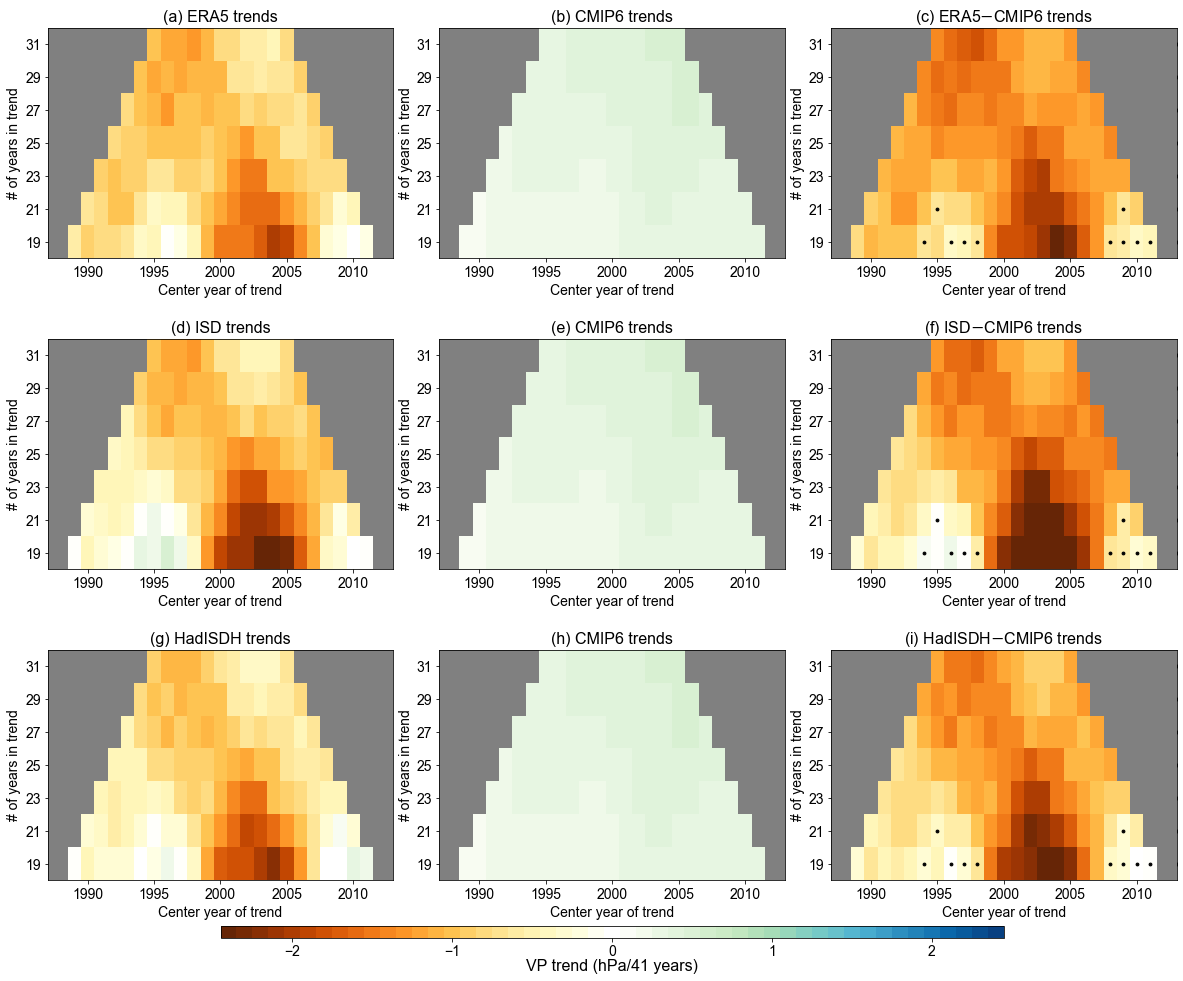

In [11]:
#---Set up the shading for the NaN trends
graymap = c.ListedColormap(['gray'])
nantrends = xr.where(np.isnan(rolling_era5_trend), 1, nan)

fig = plt.figure(figsize=(16,16))

#---------ERA5

ax = fig.add_axes([0.02,0.72,0.3,0.2])
ax.set_xlim(1987,2013)
ax.set_yticks([19,21,23,25,27,29,31])
ax.set_yticklabels(['19','21','23','25','27','29','31'], fontsize=14)
ax.set_xticks([1990,1995,2000,2005,2010])
ax.set_xticklabels(['1990','1995','2000','2005','2010'], fontsize=14)
ax.set_xlabel('Center year of trend', fontsize=14)
ax.set_ylabel('# of years in trend', fontsize=14)
ax.set_title('(a) ERA5 trends', fontsize=16)

cmax=2.4 ; cmin=-2.4 ; ci=0.1
nlevs = (cmax - cmin)/ci + 1
clevs = np.arange(cmin, cmax+ci, ci)
mymap = mycolors.precip_cmap(nlevs)
norm = BoundaryNorm(clevs, ncolors=mymap.N, clip=True)

ax.pcolormesh( rolling_era5_trend.year, rolling_era5_trend.yintrend, rolling_era5_trend, cmap=mymap, norm=norm)
ax.pcolormesh( nantrends.year, nantrends.yintrend, nantrends, cmap=graymap)


ax = fig.add_axes([0.36,0.72,0.3,0.2])
ax.set_xlim(1987,2013)
ax.set_yticks([19,21,23,25,27,29,31])
ax.set_yticklabels(['19','21','23','25','27','29','31'], fontsize=14)
ax.set_xticks([1990,1995,2000,2005,2010])
ax.set_xticklabels(['1990','1995','2000','2005','2010'], fontsize=14)
ax.set_xlabel('Center year of trend', fontsize=14)
ax.set_ylabel('# of years in trend', fontsize=14)
ax.set_title('(b) CMIP6 trends', fontsize=16)


clevs = np.arange(cmin, cmax+ci, ci)
mymap = mycolors.precip_cmap(nlevs)
norm = BoundaryNorm(clevs, ncolors=mymap.N, clip=True)

ax.pcolormesh( rolling_cmip6_trend.year, rolling_cmip6_trend.yintrend, rolling_cmip6_trend_modelmean, cmap=mymap, norm=norm)
ax.pcolormesh( nantrends.year, nantrends.yintrend, nantrends, cmap=graymap)

ax = fig.add_axes([0.7,0.72,0.3,0.2])

ax.set_xlim(1987,2013)
ax.set_yticks([19,21,23,25,27,29,31])
ax.set_yticklabels(['19','21','23','25','27','29','31'], fontsize=14)
ax.set_xticks([1990,1995,2000,2005,2010])
ax.set_xticklabels(['1990','1995','2000','2005','2010'], fontsize=14)
ax.set_xlabel('Center year of trend', fontsize=14)
ax.set_ylabel('# of years in trend', fontsize=14)
ax.set_title('(c) ERA5$-$CMIP6 trends', fontsize=16)

clevs = np.arange(cmin, cmax+ci, ci)
mymap = mycolors.precip_cmap(nlevs)
norm = BoundaryNorm(clevs, ncolors=mymap.N, clip=True)

ax.pcolormesh( rolling_cmip6_trend.year, rolling_cmip6_trend.yintrend, rolling_era5_trend - rolling_cmip6_trend_modelmean, cmap=mymap, norm=norm)

signifdat = difsignif.stack(z=("yintrend","year"))
signifdat = signifdat.dropna("z")
ax.scatter(signifdat.year, signifdat.yintrend, s=8, color='black')

ax.pcolormesh( nantrends.year, nantrends.yintrend, nantrends, cmap=graymap)

#ax = cbars.plotcolorbar(fig, 0.1, -2, 2, 'VP trend (hPa/41 years)',0.17,0.85,0.64,0.65, cmap='precip')

#--------ISD figures

ax = fig.add_axes([0.02,0.45,0.3,0.2])
ax.set_xlim(1987,2013)
ax.set_yticks([19,21,23,25,27,29,31])
ax.set_yticklabels(['19','21','23','25','27','29','31'], fontsize=14)
ax.set_xticks([1990,1995,2000,2005,2010])
ax.set_xticklabels(['1990','1995','2000','2005','2010'], fontsize=14)
ax.set_xlabel('Center year of trend', fontsize=14)
ax.set_ylabel('# of years in trend', fontsize=14)
ax.set_title('(d) ISD trends', fontsize=16)

clevs = np.arange(cmin, cmax+ci, ci)
mymap = mycolors.precip_cmap(nlevs)
norm = BoundaryNorm(clevs, ncolors=mymap.N, clip=True)

ax.pcolormesh( rolling_isd_trend.year, rolling_isd_trend.yintrend, rolling_isd_trend, cmap=mymap, norm=norm)
ax.pcolormesh( nantrends.year, nantrends.yintrend, nantrends, cmap=graymap)


ax = fig.add_axes([0.36,0.45,0.3,0.2])
ax.set_xlim(1987,2013)
ax.set_yticks([19,21,23,25,27,29,31])
ax.set_yticklabels(['19','21','23','25','27','29','31'], fontsize=14)
ax.set_xticks([1990,1995,2000,2005,2010])
ax.set_xticklabels(['1990','1995','2000','2005','2010'], fontsize=14)
ax.set_xlabel('Center year of trend', fontsize=14)
ax.set_ylabel('# of years in trend', fontsize=14)
ax.set_title('(e) CMIP6 trends', fontsize=16)

clevs = np.arange(cmin, cmax+ci, ci)
mymap = mycolors.precip_cmap(nlevs)
norm = BoundaryNorm(clevs, ncolors=mymap.N, clip=True)

ax.pcolormesh( rolling_cmip6_trend.year, rolling_cmip6_trend.yintrend, rolling_cmip6_trend_modelmean, cmap=mymap, norm=norm)
ax.pcolormesh( nantrends.year, nantrends.yintrend, nantrends, cmap=graymap)

ax = fig.add_axes([0.7,0.45,0.3,0.2])

ax.set_xlim(1987,2013)
ax.set_yticks([19,21,23,25,27,29,31])
ax.set_yticklabels(['19','21','23','25','27','29','31'], fontsize=14)
ax.set_xticks([1990,1995,2000,2005,2010])
ax.set_xticklabels(['1990','1995','2000','2005','2010'], fontsize=14)
ax.set_xlabel('Center year of trend', fontsize=14)
ax.set_ylabel('# of years in trend', fontsize=14)
ax.set_title('(f) ISD$-$CMIP6 trends', fontsize=16)

clevs = np.arange(cmin, cmax+ci, ci)
mymap = mycolors.precip_cmap(nlevs)
norm = BoundaryNorm(clevs, ncolors=mymap.N, clip=True)

ax.pcolormesh( rolling_cmip6_trend.year, rolling_cmip6_trend.yintrend, rolling_isd_trend - rolling_cmip6_trend_modelmean, cmap=mymap, norm=norm)

signifdat = difsignif.stack(z=("yintrend","year"))
signifdat = signifdat.dropna("z")
ax.scatter(signifdat.year, signifdat.yintrend, s=8, color='black')

ax.pcolormesh( nantrends.year, nantrends.yintrend, nantrends, cmap=graymap)

#ax = cbars.plotcolorbar(fig, 0.1, -2, 2, 'VP trend (hPa/41 years)',0.17,0.85,0.39,0.4, cmap='precip')


#-----------------HadISDH
ax = fig.add_axes([0.02,0.18,0.3,0.2])
ax.set_xlim(1987,2013)
ax.set_yticks([19,21,23,25,27,29,31])
ax.set_yticklabels(['19','21','23','25','27','29','31'], fontsize=14)
ax.set_xticks([1990,1995,2000,2005,2010])
ax.set_xticklabels(['1990','1995','2000','2005','2010'], fontsize=14)
ax.set_xlabel('Center year of trend', fontsize=14)
ax.set_ylabel('# of years in trend', fontsize=14)
ax.set_title('(g) HadISDH trends', fontsize=16)

clevs = np.arange(cmin, cmax+ci, ci)
mymap = mycolors.precip_cmap(nlevs)
norm = BoundaryNorm(clevs, ncolors=mymap.N, clip=True)

ax.pcolormesh( rolling_hadisdh_trend.year, rolling_hadisdh_trend.yintrend, rolling_hadisdh_trend, cmap=mymap, norm=norm)
ax.pcolormesh( nantrends.year, nantrends.yintrend, nantrends, cmap=graymap)


ax = fig.add_axes([0.36,0.18,0.3,0.2])
ax.set_xlim(1987,2013)
ax.set_yticks([19,21,23,25,27,29,31])
ax.set_yticklabels(['19','21','23','25','27','29','31'], fontsize=14)
ax.set_xticks([1990,1995,2000,2005,2010])
ax.set_xticklabels(['1990','1995','2000','2005','2010'], fontsize=14)
ax.set_xlabel('Center year of trend', fontsize=14)
ax.set_ylabel('# of years in trend', fontsize=14)
ax.set_title('(h) CMIP6 trends', fontsize=16)

clevs = np.arange(cmin, cmax+ci, ci)
mymap = mycolors.precip_cmap(nlevs)
norm = BoundaryNorm(clevs, ncolors=mymap.N, clip=True)

ax.pcolormesh( rolling_cmip6_trend.year, rolling_cmip6_trend.yintrend, rolling_cmip6_trend_modelmean, cmap=mymap, norm=norm)
ax.pcolormesh( nantrends.year, nantrends.yintrend, nantrends, cmap=graymap)


ax = fig.add_axes([0.7,0.18,0.3,0.2])
ax.set_xlim(1987,2013)
ax.set_yticks([19,21,23,25,27,29,31])
ax.set_yticklabels(['19','21','23','25','27','29','31'], fontsize=14)
ax.set_xticks([1990,1995,2000,2005,2010])
ax.set_xticklabels(['1990','1995','2000','2005','2010'], fontsize=14)
ax.set_xlabel('Center year of trend', fontsize=14)
ax.set_ylabel('# of years in trend', fontsize=14)
ax.set_title('(i) HadISDH$-$CMIP6 trends', fontsize=16)

clevs = np.arange(cmin, cmax+ci, ci)
mymap = mycolors.precip_cmap(nlevs)
norm = BoundaryNorm(clevs, ncolors=mymap.N, clip=True)

ax.pcolormesh( rolling_cmip6_trend.year, rolling_cmip6_trend.yintrend, rolling_hadisdh_trend - rolling_cmip6_trend_modelmean, cmap=mymap, norm=norm)

signifdat = difsignif.stack(z=("yintrend","year"))
signifdat = signifdat.dropna("z")
ax.scatter(signifdat.year, signifdat.yintrend, s=8, color='black')

ax.pcolormesh( nantrends.year, nantrends.yintrend, nantrends, cmap=graymap)

ax = cbars.plotcolorbar(fig, ci, cmin, cmax, 'VP trend (hPa/41 years)',0.17,0.85,0.13,0.14, cmap='precip')

fig.savefig(plotpath+'figS7.pdf', bbox_inches='tight', facecolor='white')